In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import load_seml, model_type_map, dataset_map
import scvelo as scv
import pandas as pd
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Global seed set to 0
/data/nasif12/home_if12/martensl/github_repos/scatac_poisson_private/poisson_atac/utils.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-poster")
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/scvelo/settings.py:91: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead

In [3]:
from utils import plot_integration_results

In [4]:
scv.set_figure_params()

In [5]:
sns.set_style("whitegrid")

In [6]:
fig_path = '/s/project/poisson_atac/panels/revision2/Figure2/integration'

## Load results

In [7]:
seml_database = 'integration'

In [8]:
df = load_seml(seml_database, convert_dataset_name=True)

100%|██████████| 320/320 [00:00<00:00, 928.05it/s]


In [9]:
df = df.sort_values(['config.data.dataset', 'config.model.model_type', 'config.data.seed'])

In [10]:
# Concatenate
df.loc[df['config.data.dataset'] == dataset_map['trapnell'], 'result.embedding'] = \
df.loc[df['config.data.dataset'] == dataset_map['trapnell'], 'result.embedding'].apply(lambda x: x.mean(axis=1).to_frame())

## Compute aggregated scores

In [11]:
scib_table = pd.concat(df.loc[:, 'result.embedding'].values, axis =1).T

In [12]:
scib_table.index = pd.MultiIndex.from_frame(
    df.loc[:, ['config.data.dataset', 'config.model.model_type', 'config.data.seed']]
)

In [13]:
bio = ['NMI_cluster/label', 'ARI_cluster/label', 'ASW_label', 'isolated_label_F1', \
       'isolated_label_silhouette', 'cLISI', 'trajectory']
batch = ['ASW_label/batch', 'PCR_batch', 'graph_conn', 'iLISI']

In [14]:
scib_table['Bio conservation'] = scib_table.loc[:, bio].mean(axis=1, skipna=True)
scib_table['Batch correction'] = scib_table.loc[:, batch].mean(axis=1, skipna=True)
scib_table['Total'] = 0.6*scib_table['Bio conservation'] + 0.4*scib_table['Batch correction']

## Plot overall scores

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sci-ATAC-seq3 Human_cisTopic vs. sci-ATAC-seq3 Human_cisTopic (Harmony): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
10x Human NeurIPS_Poisson VAE vs. 10x Human NeurIPS_Binary VAE: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.711e-02 Stat=7.000e+00
10x Human Satpathy_Poisson VAE vs. 10x Human Satpathy_Binary VAE: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.602e-01 Stat=1.300e+01
10x Fly_Poisson VAE vs. 10x Fly_Binary VAE: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.906e-03 Stat=1.000e+00
10x Human Satpathy_Poisson VAE vs. 10x Human Satpathy_PeakVI: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
10x Fly_Poisson VAE 

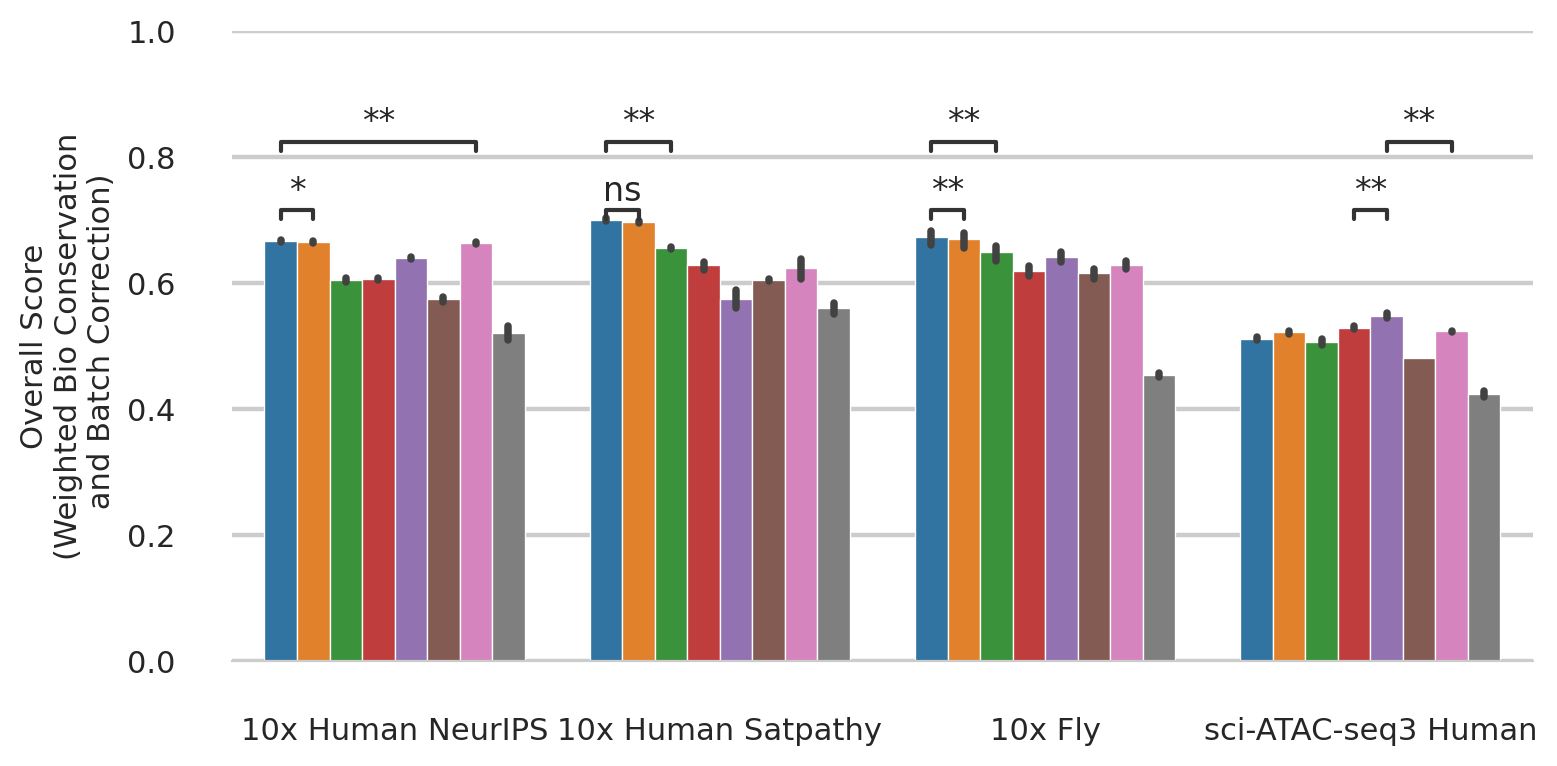

In [15]:
order = [dataset_map[key] for key in ['neurips',  'satpathy', 'aerts', 'trapnell']]

from statannotations.Annotator import Annotator
from utils import model_palette

fig, ax = plt.subplots(figsize=(8,4))
ax = sns.barplot(
    data=scib_table.reset_index(), 
    x='config.data.dataset', 
    y='Total', 
    hue='config.model.model_type', 
    ax = ax, 
    order=order,
    palette=model_palette
)
annot = Annotator(
        ax,
        pairs=[((dataset_map['neurips'], model_type_map['poissonvi']), 
                (dataset_map['neurips'], model_type_map['binaryvi'])),
               #
               ((dataset_map['neurips'], model_type_map['poissonvi']), 
                (dataset_map['neurips'], model_type_map['signac_harmony'])),
               ##
                ((dataset_map['satpathy'], model_type_map['poissonvi']), 
                (dataset_map['satpathy'], model_type_map['binaryvi'])),
               #
                ((dataset_map['satpathy'], model_type_map['poissonvi']), 
                (dataset_map['satpathy'], model_type_map['peakvi'])),
               ##
                ((dataset_map['aerts'], model_type_map['poissonvi']), 
                (dataset_map['aerts'], model_type_map['binaryvi'])),
               #
                ((dataset_map['aerts'], model_type_map['poissonvi']), 
                (dataset_map['aerts'], model_type_map['peakvi'])),
               ##
                ((dataset_map['trapnell'], model_type_map['cistopic_harmony']), 
                (dataset_map['trapnell'], model_type_map['cistopic'])),
               #
                ((dataset_map['trapnell'], model_type_map['cistopic_harmony']), 
                (dataset_map['trapnell'], model_type_map['signac_harmony'])),
              ],
        data=scib_table.reset_index(),
        x='config.data.dataset',
        y='Total',
        hue='config.model.model_type',
        order = order,
        palette=model_palette
    )
annot.configure(
    test='Wilcoxon',
    text_format='star',
    loc="outside",
    comparisons_correction="Benjamini-Hochberg",
    verbose=2,
)
annot.apply_test()
ax, _ = annot.annotate(line_offset=-0.05, line_offset_to_group=0)
ax.legend().remove()
sns.despine(left=True)
plt.ylim((0,1))
plt.ylabel('Overall Score\n(Weighted Bio Conservation\n and Batch Correction)')
plt.xlabel('')
plt.tight_layout()
fig.savefig(os.path.join(fig_path,  f'overall_score_bar.pdf'))
fig.savefig(os.path.join(fig_path,  f'overall_score_bar.png'))

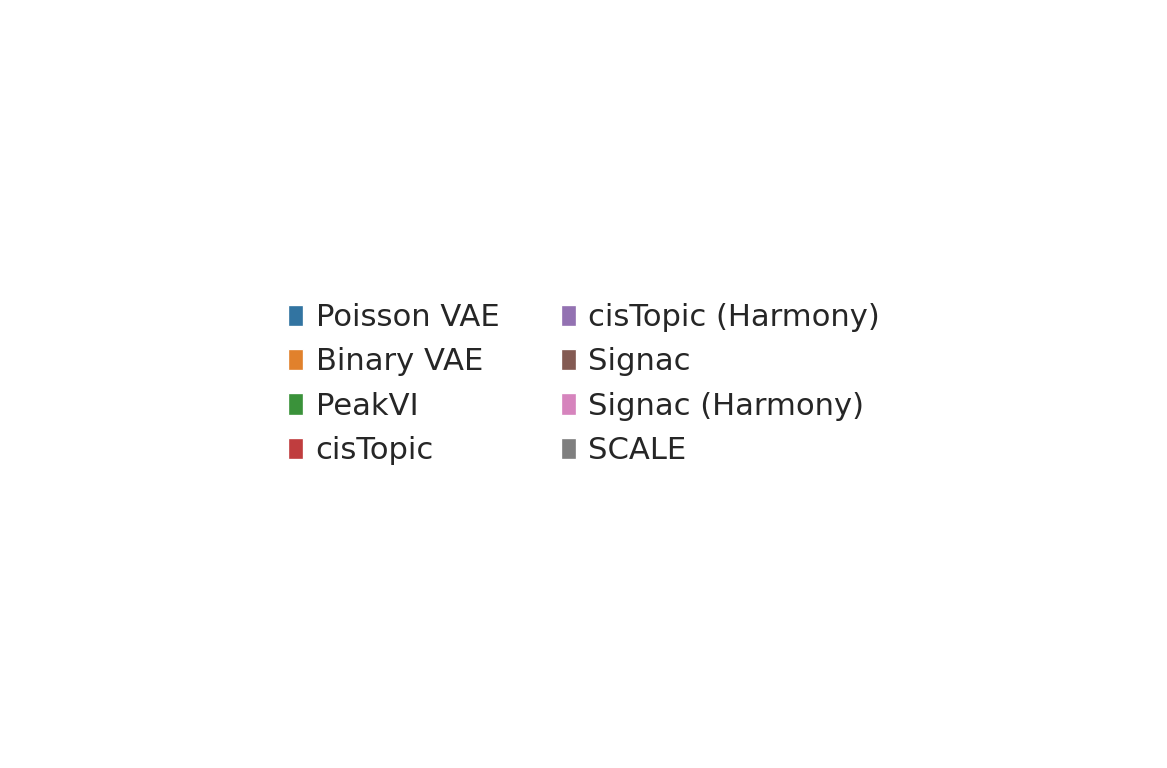

In [16]:
# Plot the legend separately
handles, labels = ax.get_legend_handles_labels()
plt.figure()
plt.axis('off')  # Turn off the axis
plt.legend(handles, labels, ncol=2, loc='center', frameon=False)

# Show the plots
plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'legend.pdf'))
plt.savefig(os.path.join(fig_path, 'legend.png'))
plt.show()

## Plot detailed table

In [17]:
df = scib_table.groupby(level=[0, 1]).mean()

10x Fly


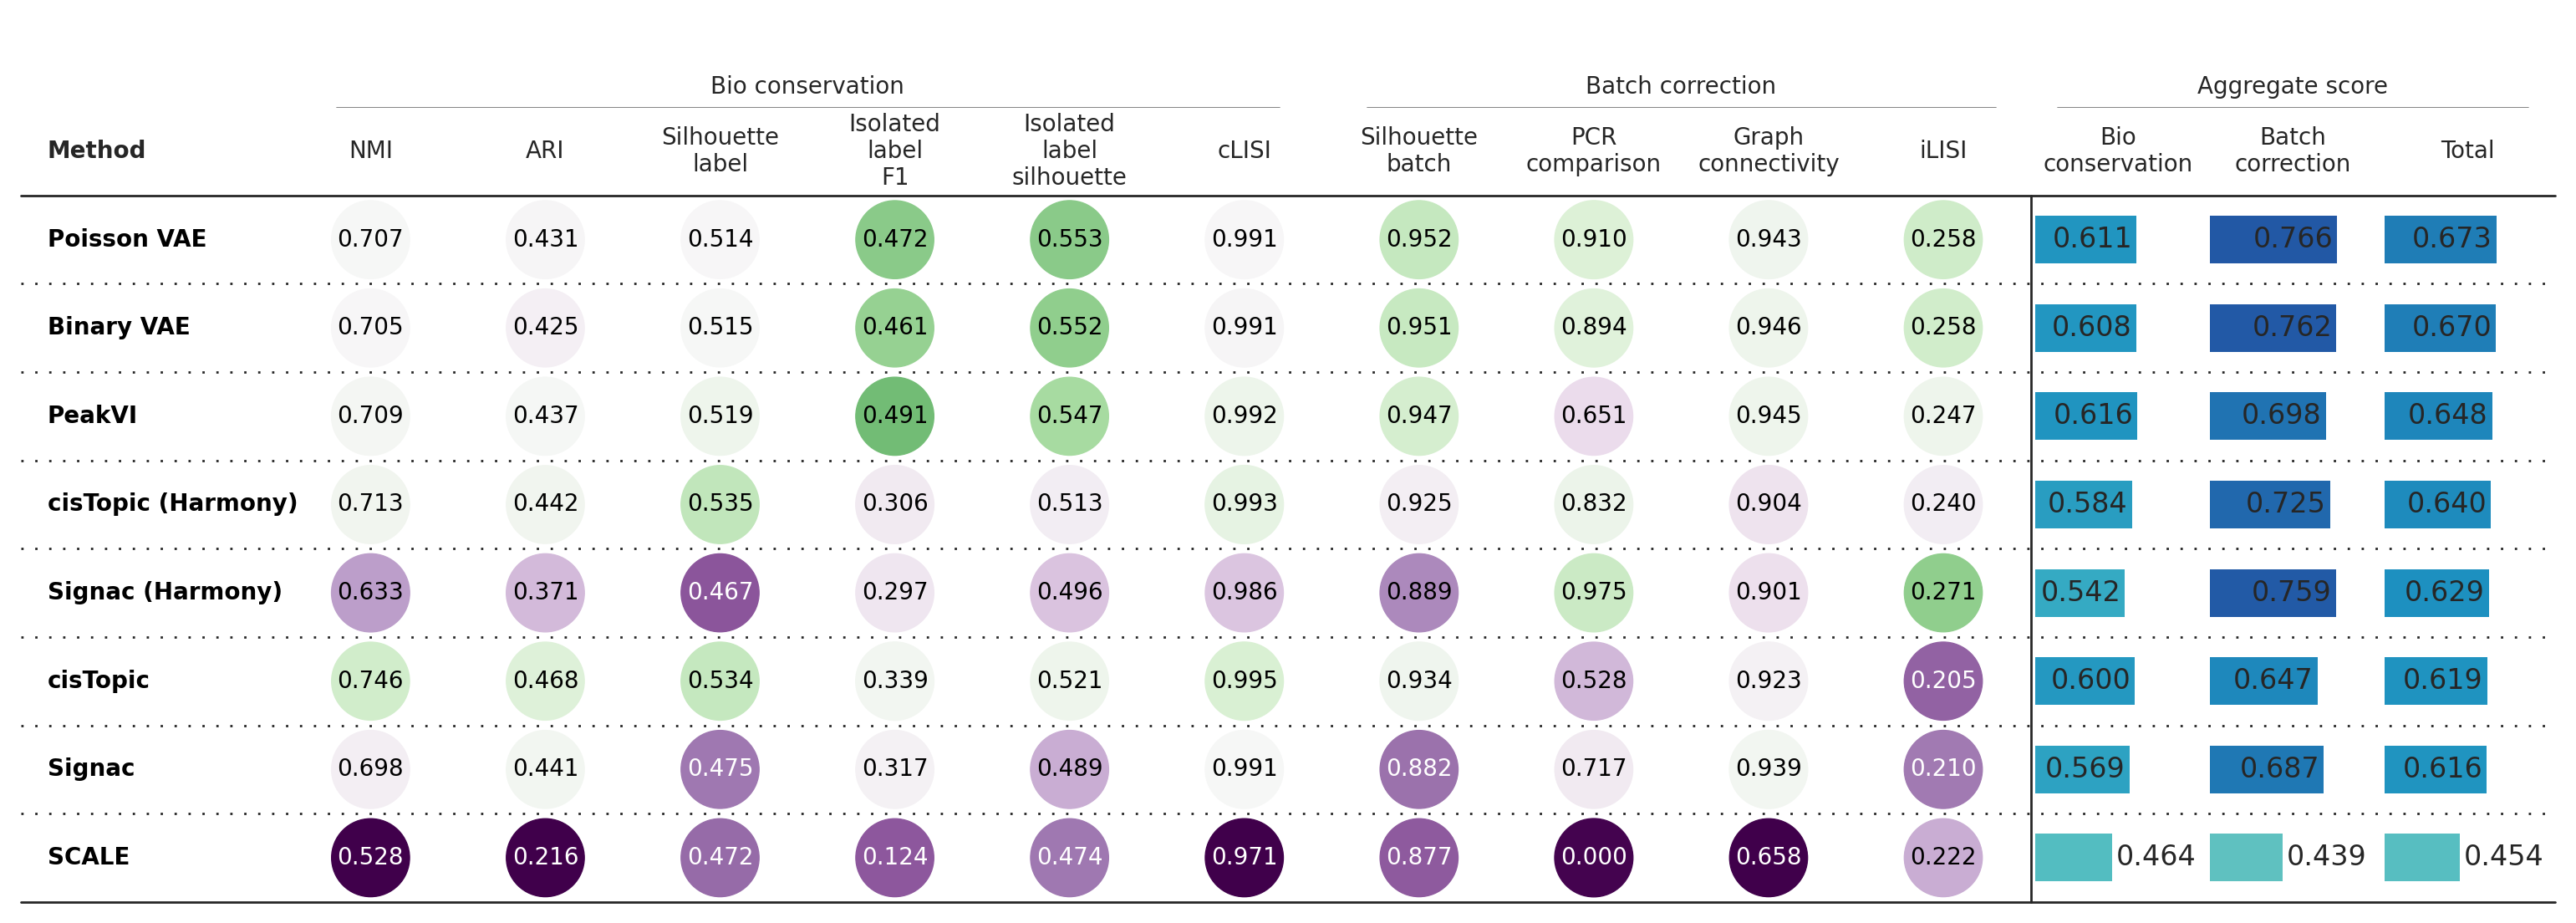

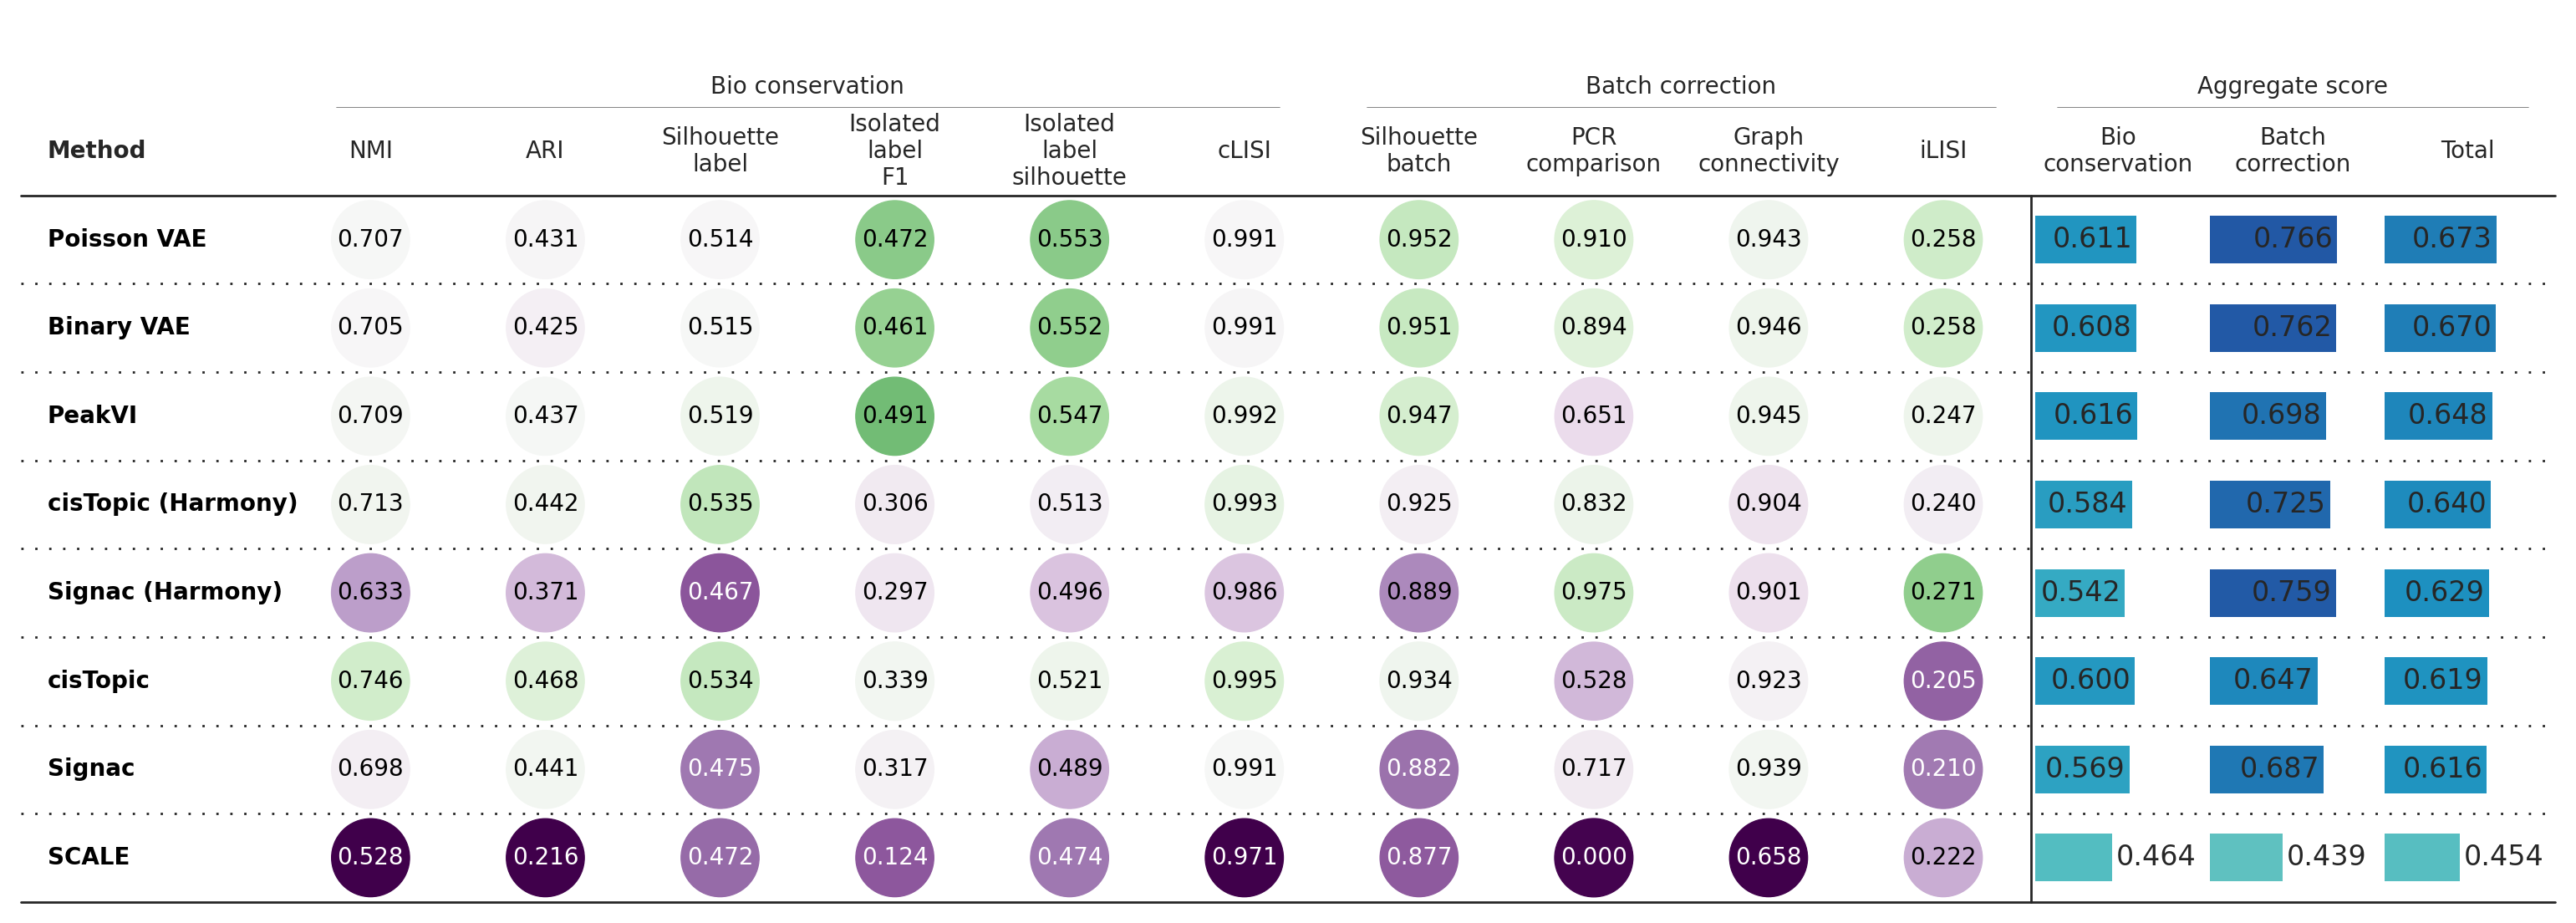

10x Human NeurIPS


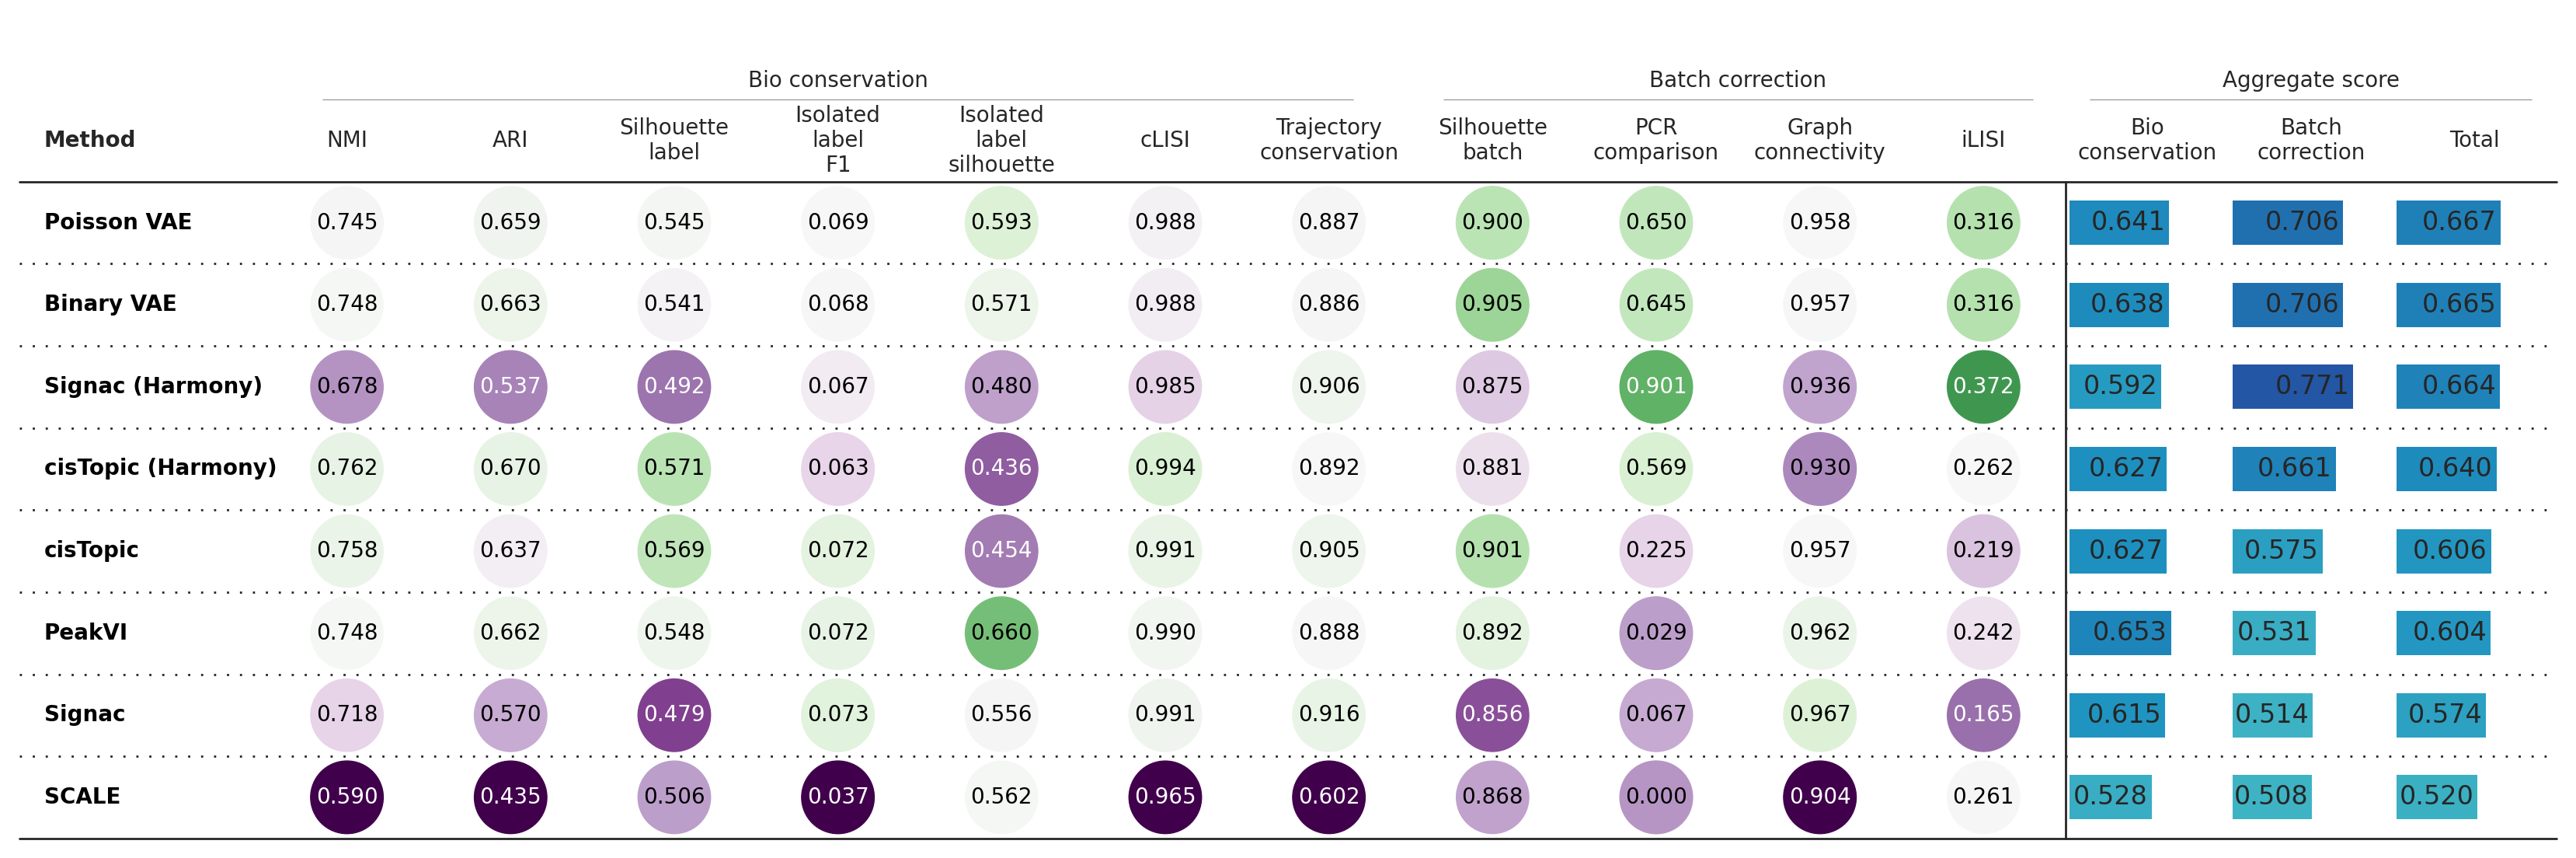

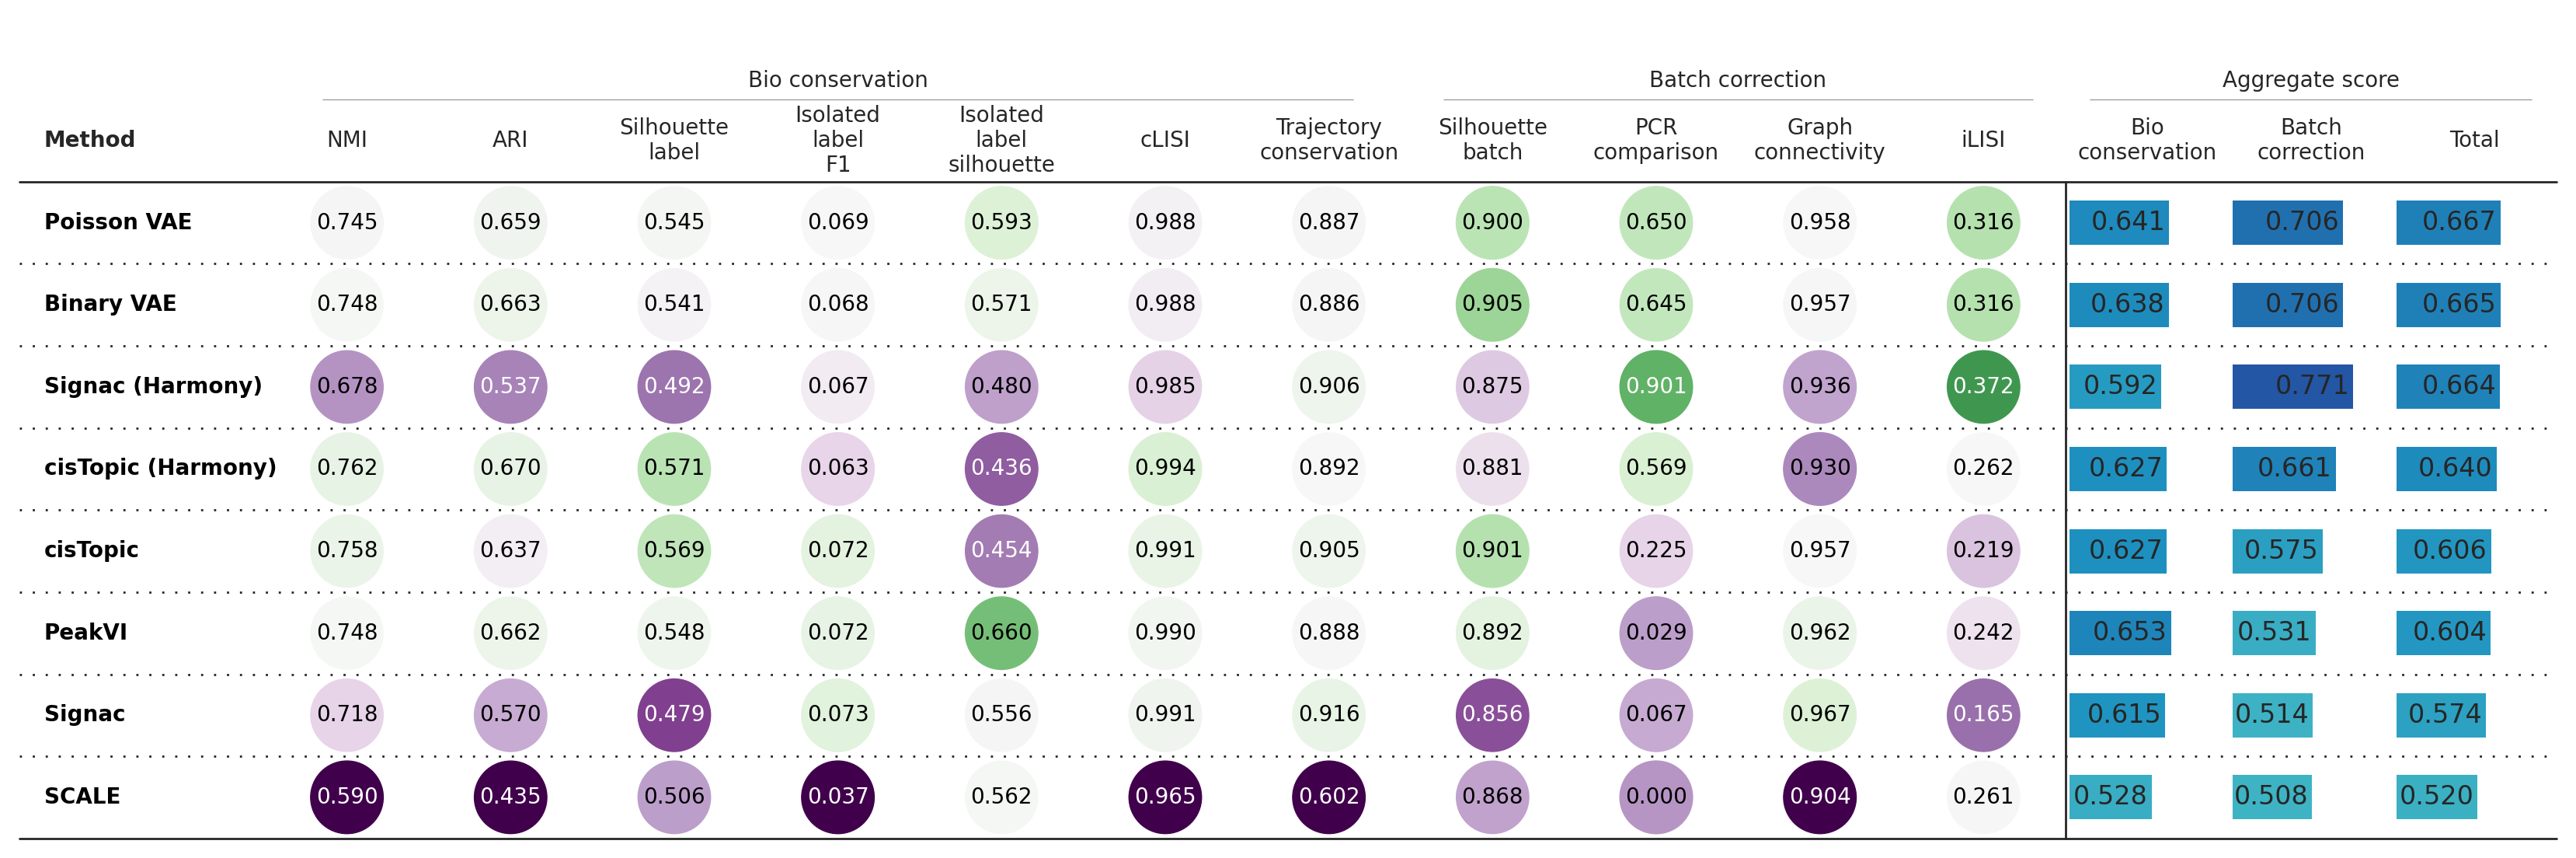

10x Human Satpathy


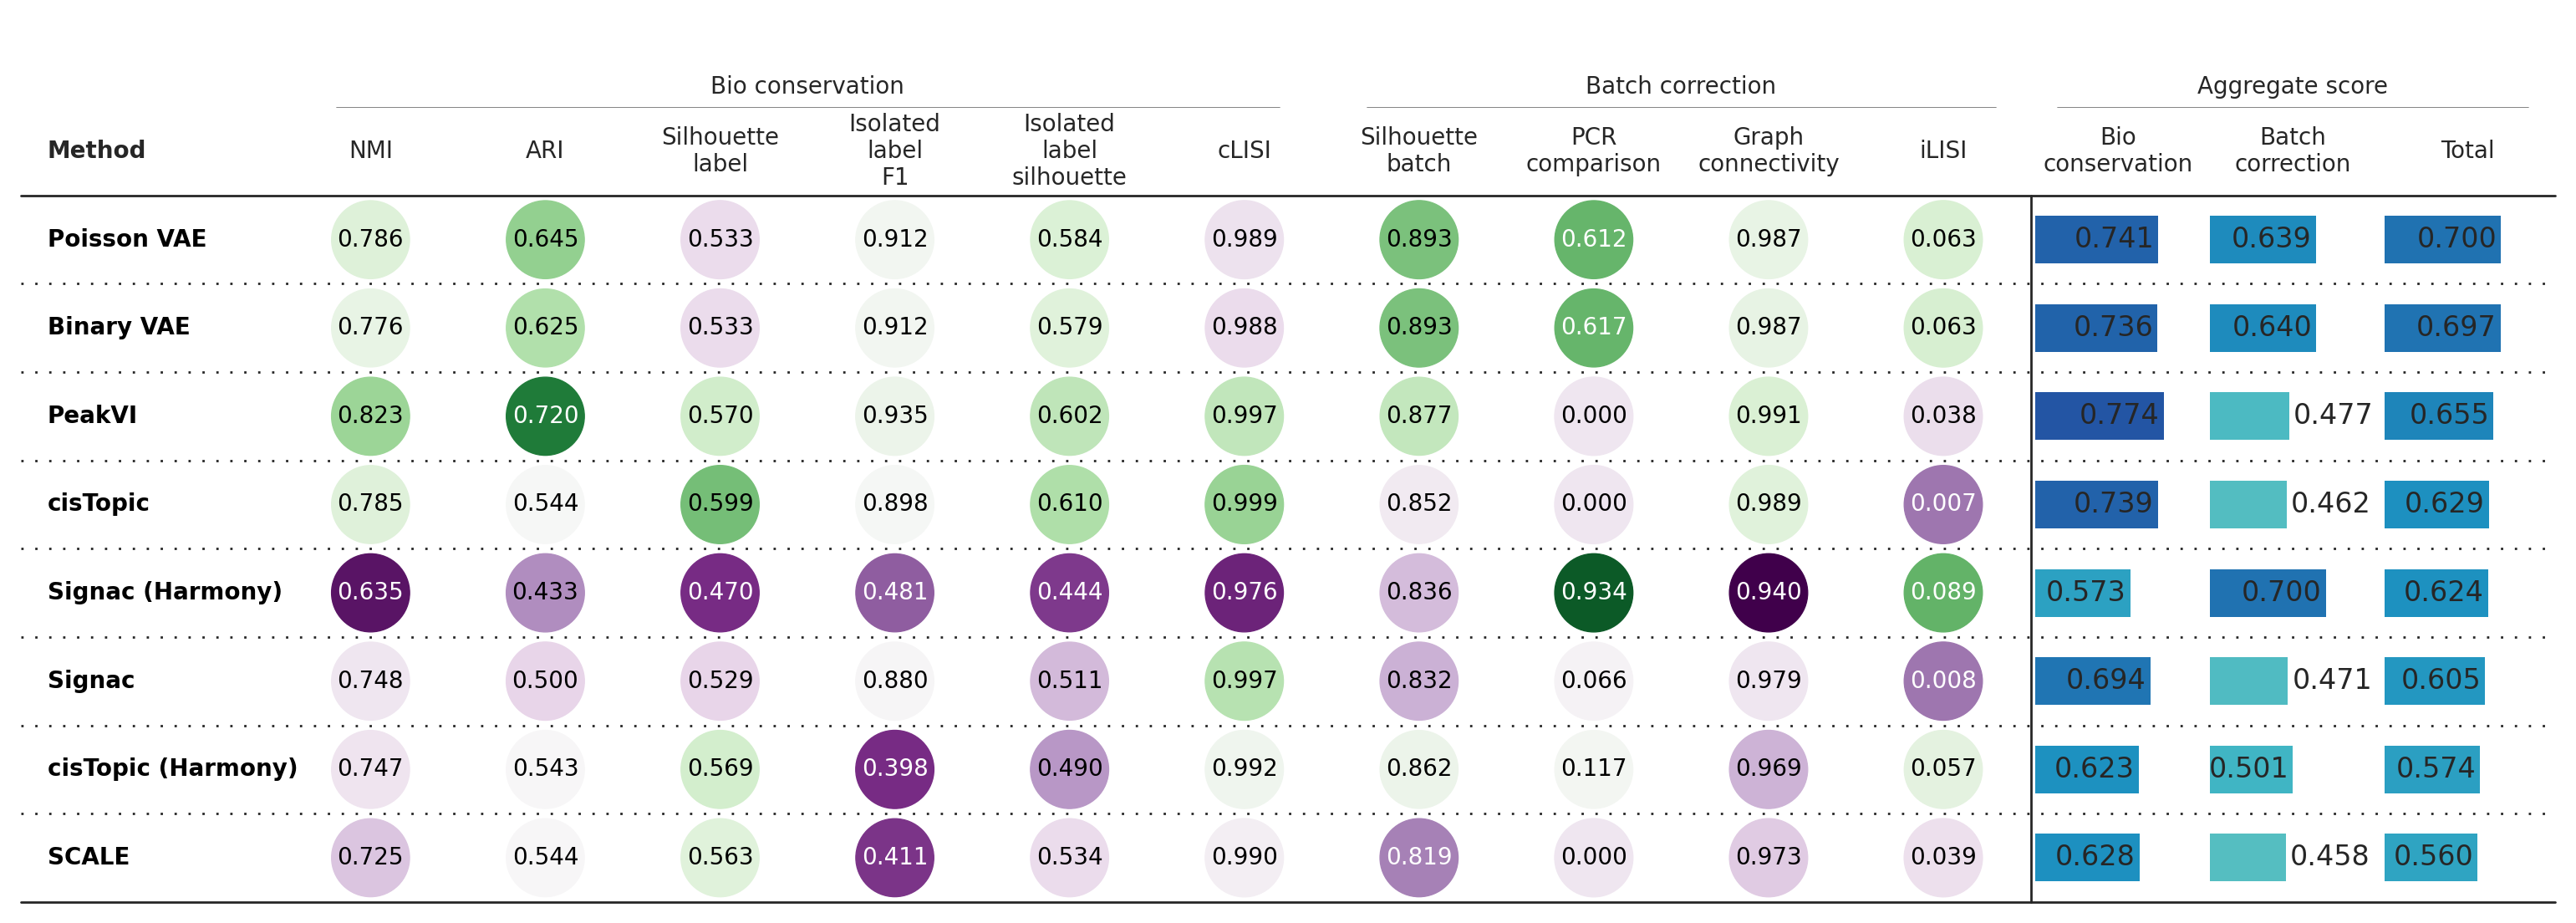

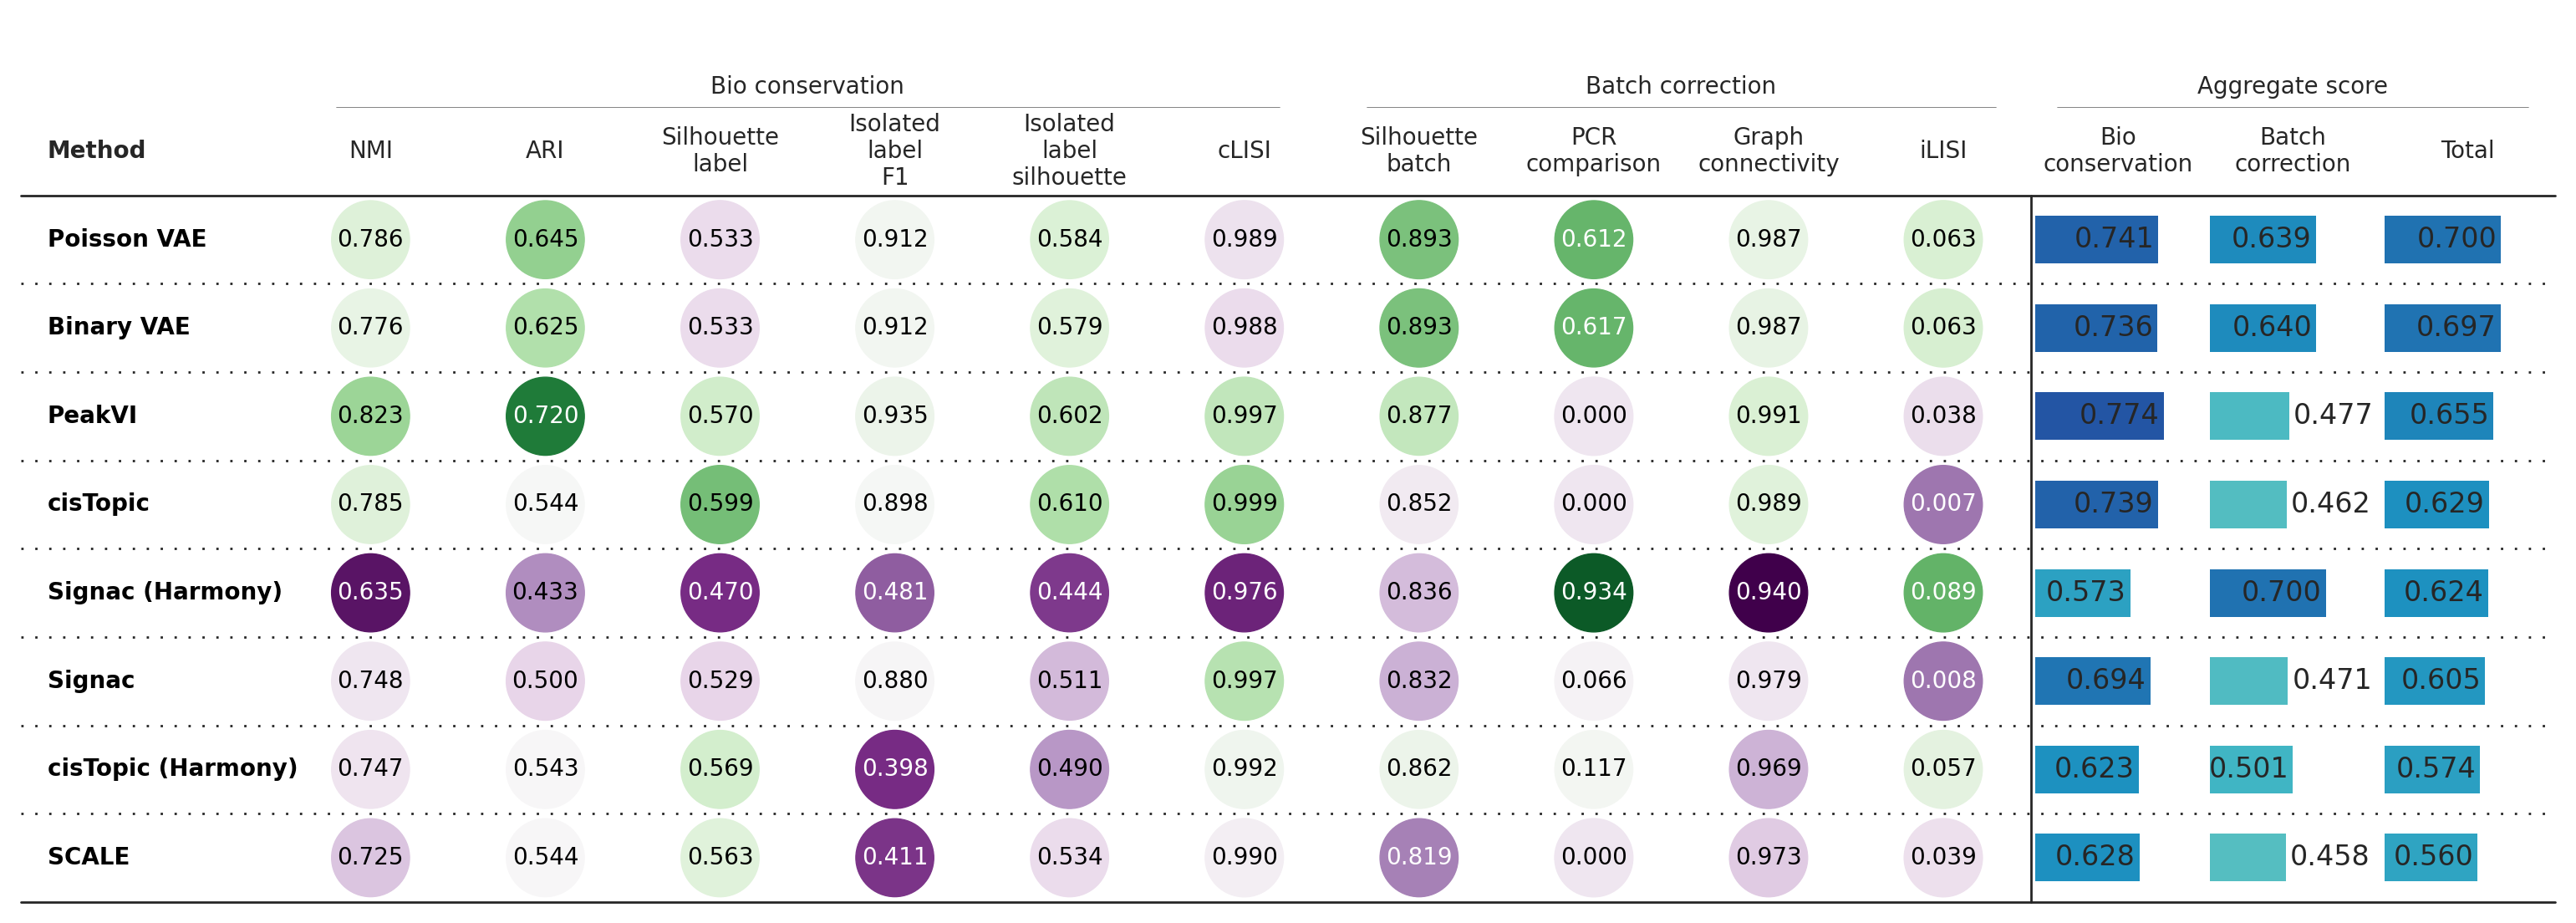

sci-ATAC-seq3 Human


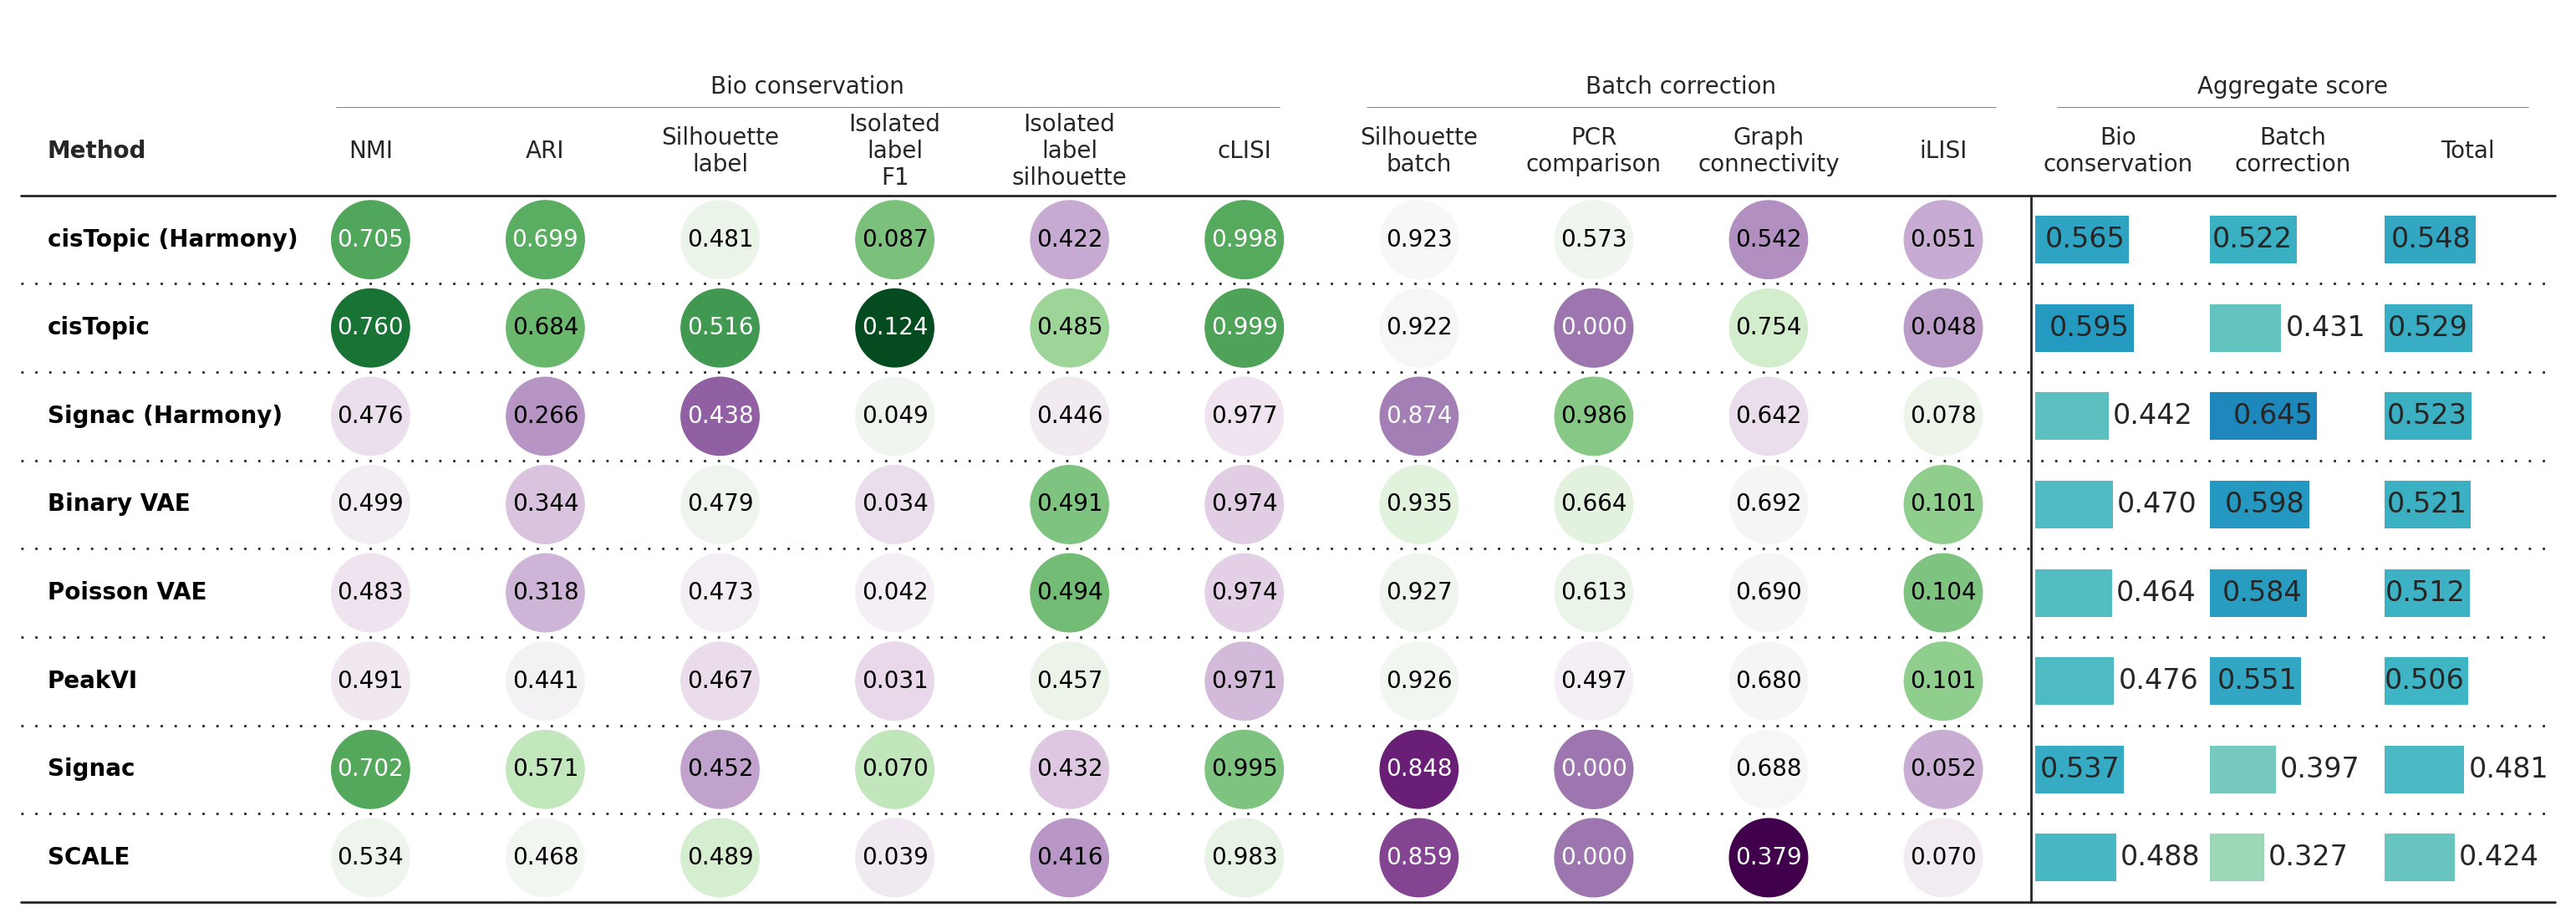

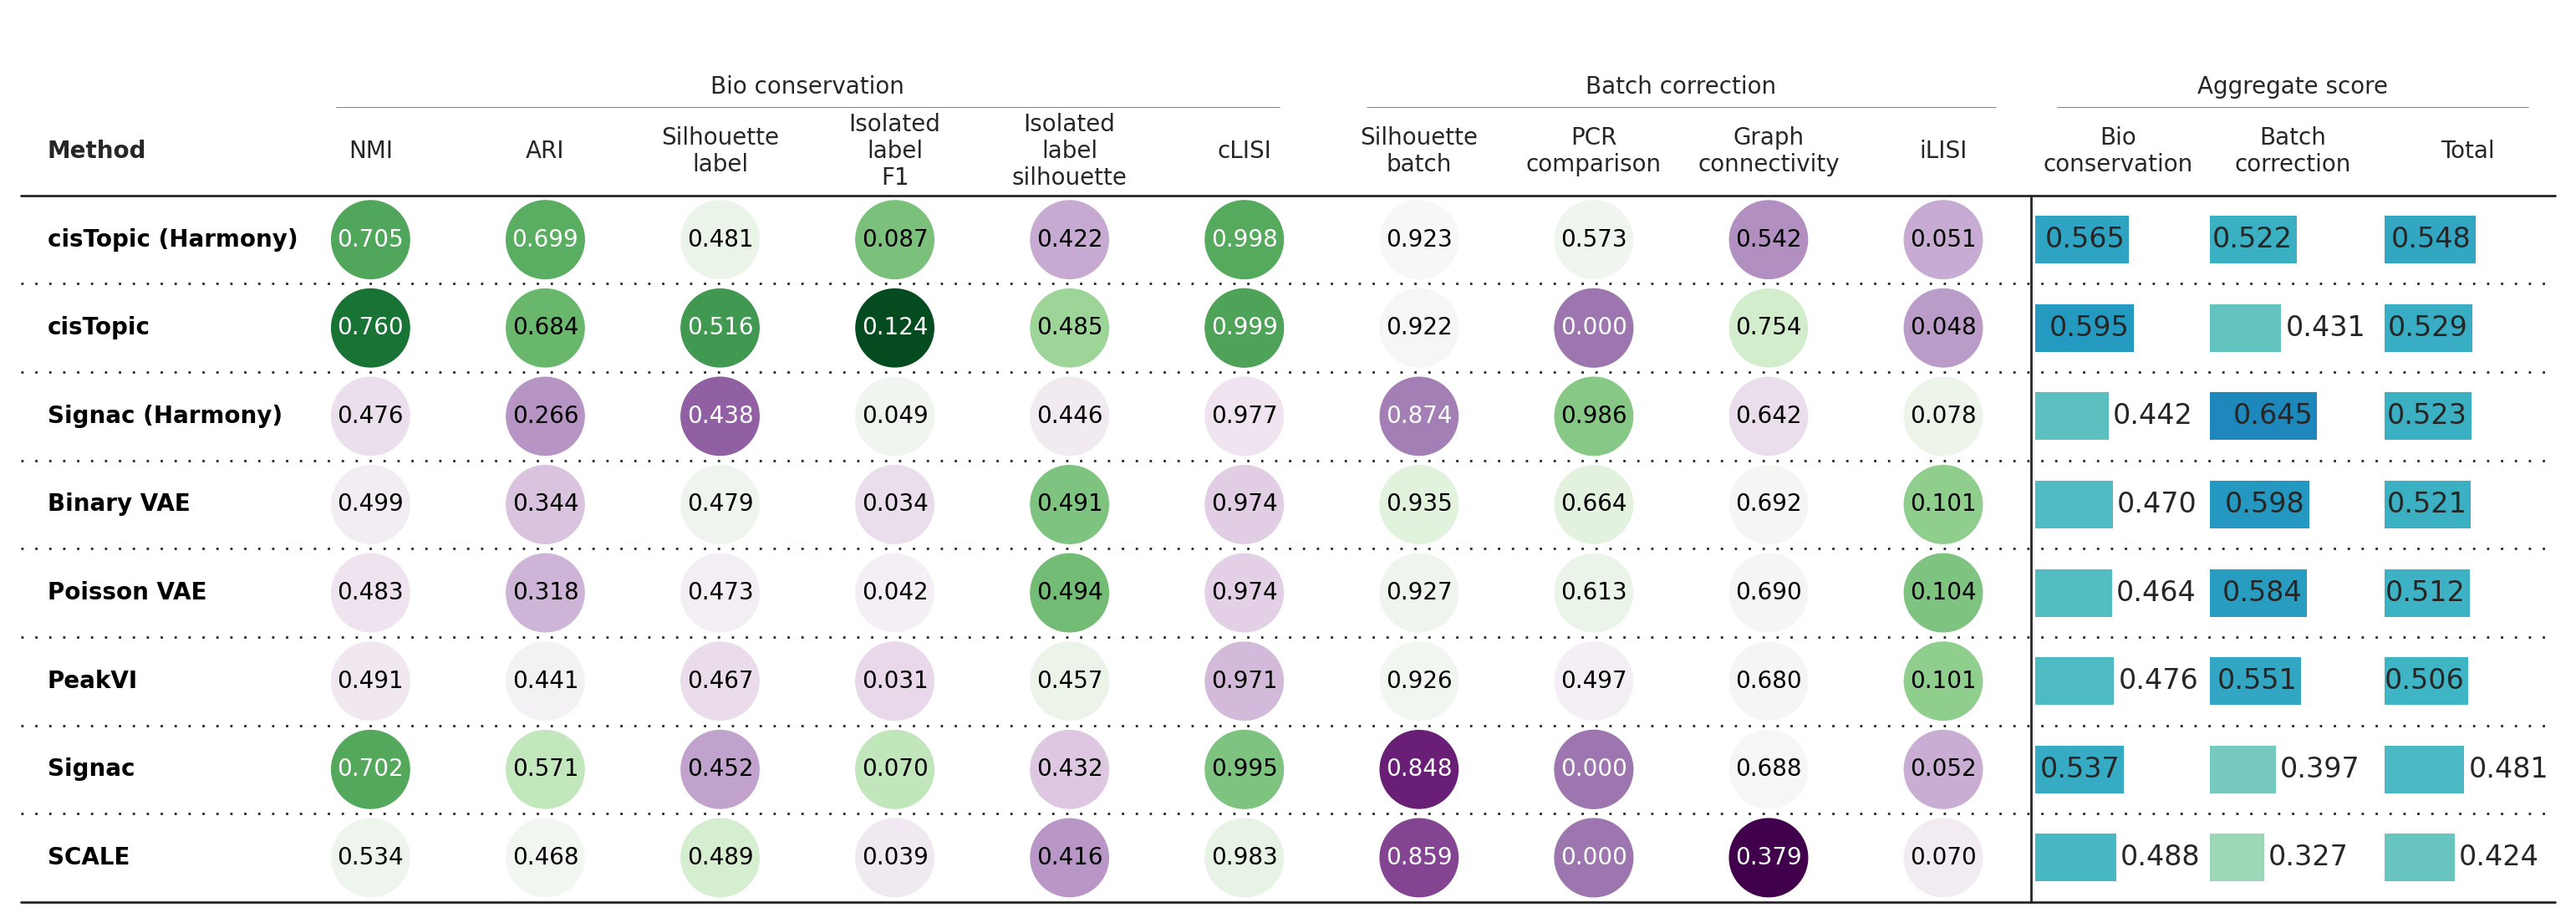

In [18]:
for dataset in df.index.levels[0]:
    print(dataset)
    sns_df = df.loc[dataset, :].T.dropna().T
    plot_integration_results(sns_df, save_path = os.path.join(fig_path, f"{dataset}_integration_results.pdf"))
    plot_integration_results(sns_df, save_path = os.path.join(fig_path, f"{dataset}_integration_results.png"))

## Try different weighting schemes

In [15]:
weightings = [(0.0, 1.0), (.1, .9),(.2, .8), (.3, .7), (.4, .6), (.5, .5), (.6, .4), (.7, .3), (.8, .2), (.9, .1), (1.0, 0.0)]
dfs = []
for w in weightings:
    scib_table['Bio conservation'] = scib_table.loc[:, bio].mean(axis=1, skipna=True)
    scib_table['Batch correction'] = scib_table.loc[:, batch].mean(axis=1, skipna=True)
    scib_table['Total'] = w[0]*scib_table['Bio conservation'] + w[1]*scib_table['Batch correction']
    sns_df = scib_table.groupby(level=[0, 1])\
            .mean()\
            .groupby(level=0)\
            .rank(ascending=False).reset_index()
    sns_df[['weighting']] = str(w)
    dfs.append(sns_df)

In [16]:
sns_df = pd.concat(dfs)

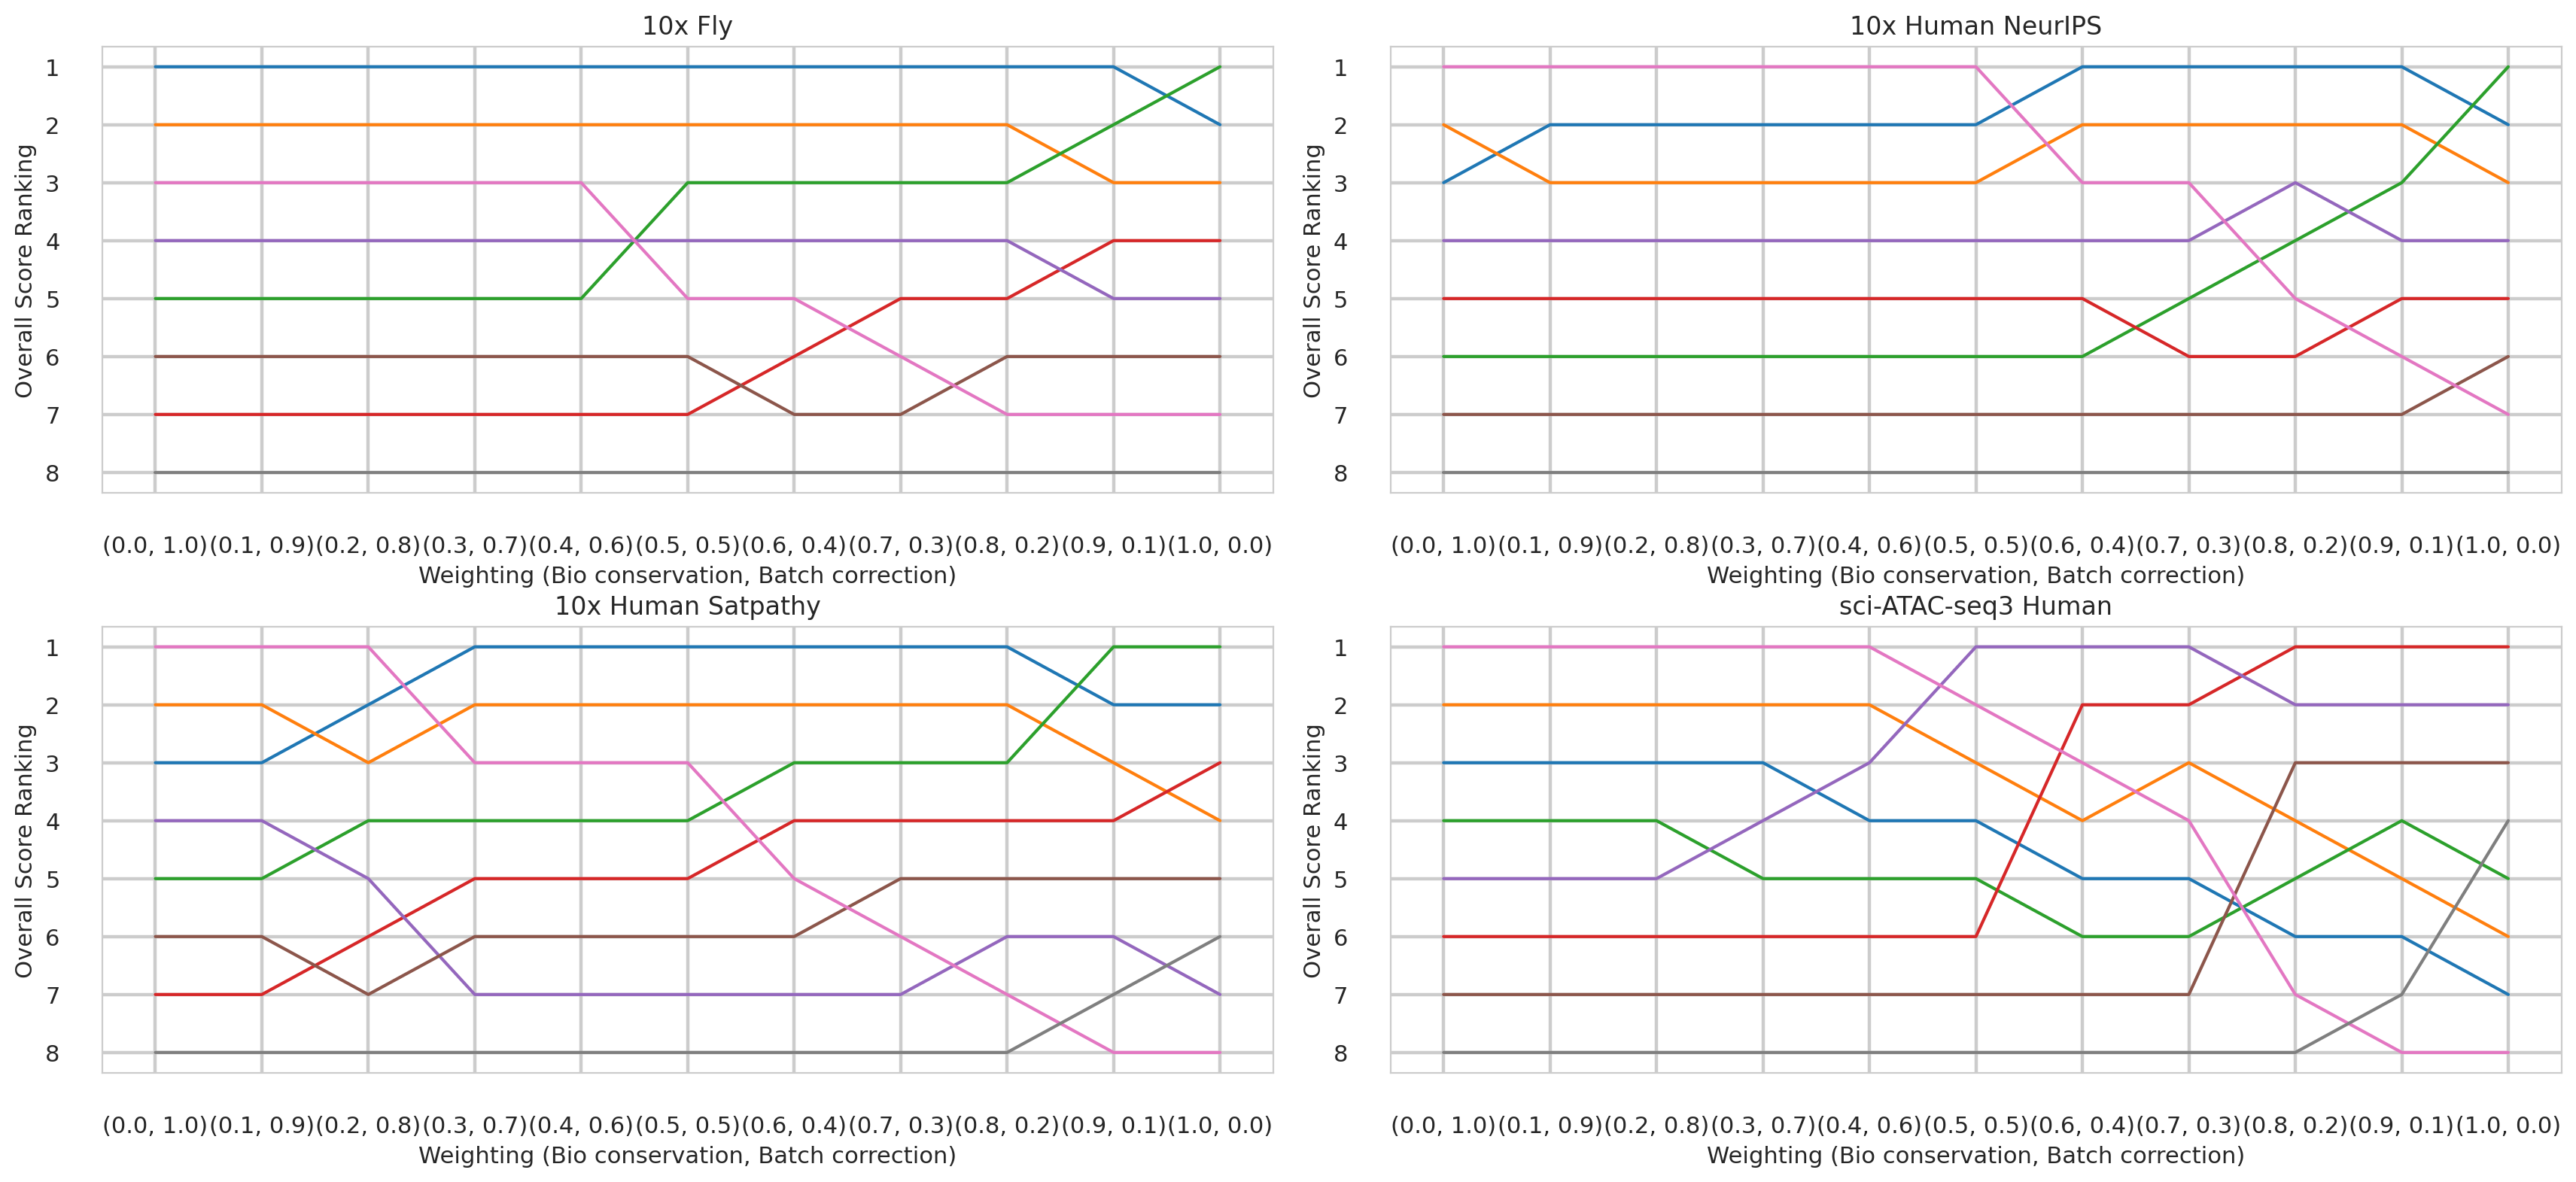

In [21]:
fig, axs = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(19, 11), 
    gridspec_kw={'wspace': 0.1, 'left': 0.12, 'hspace': 0.3}
) 

plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for i, (dataset, group) in enumerate(sns_df.groupby('config.data.dataset')):
    sns.lineplot(
        data=group.reset_index(), 
        x='weighting', 
        y='Total', 
        hue='config.model.model_type',
        ax=axs[i//2, i%2]
    )
    axs[i//2, i%2].set(
        title=dataset, 
        ylabel='Overall Score Ranking',
        xlabel='Weighting (Bio conservation, Batch correction)'
    )
    axs[i//2, i%2].legend().remove()
    axs[i//2, i%2].invert_yaxis()
fig.savefig(os.path.join(fig_path, f"overall_score_ranking.png"))
fig.savefig(os.path.join(fig_path, f"overall_score_ranking.pdf"))